## DC2 Classification Accuracy

In [1]:
import torch
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat
from case_studies.dc2_cataloging.utils.safe_metric_collection import SafeMetricCollection as MetricCollection

output_dir = Path("./classification_accuracy_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp/exp_06-16-2/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
_, test_image_cat, bliss_full_cat, lsst_full_cat = get_full_cat(notebook_cfg, 
                                                                0, 
                                                                model_path, 
                                                                lsst_root_dir, 
                                                                device)

In [4]:
matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_metrics = instantiate(notebook_cfg.encoder.metrics)
bliss_metrics = MetricCollection({
    "source_type_accuracy": bliss_metrics["source_type_accuracy"],
    "source_type_accuracy_star": bliss_metrics["source_type_accuracy_star"],
    "source_type_accuracy_galaxy": bliss_metrics["source_type_accuracy_galaxy"],
}).to(device=device)
lsst_metrics = bliss_metrics.clone()

bliss_results = {}
lsst_results = {}

classification_result_path = output_dir / "classification_result.pkl"
if not classification_result_path.exists():
    bliss_matching = list(matcher.match_catalogs(test_image_cat, bliss_full_cat)[0])
    lsst_matching = list(matcher.match_catalogs(test_image_cat, lsst_full_cat)[0])

    matching_inter = (bliss_matching[0].view(-1, 1) == lsst_matching[0].view(1, -1))
    bliss_matching[0], bliss_matching[1] = bliss_matching[0][matching_inter.any(dim=-1)], bliss_matching[1][matching_inter.any(dim=-1)]
    lsst_matching[0], lsst_matching[1] = lsst_matching[0][matching_inter.any(dim=0)], lsst_matching[1][matching_inter.any(dim=0)]
    
    bliss_metrics.update(test_image_cat, bliss_full_cat, [bliss_matching])
    lsst_metrics.update(test_image_cat, lsst_full_cat, [lsst_matching])

    for k, v in bliss_metrics.items():
        resutls = v.get_results_on_per_flux_bin()
        for k_results, v_results in resutls.items():
            bliss_results[k_results] = v_results.cpu()

    for k, v in lsst_metrics.items():
        resutls = v.get_results_on_per_flux_bin()
        for k_results, v_results in resutls.items():
            lsst_results[k_results] = v_results.cpu()

        with open(classification_result_path, "wb") as classification_result_file:
                pickle.dump({
                    "bliss_results": bliss_results,
                    "lsst_results": lsst_results,
                }, classification_result_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(classification_result_path, "rb") as classification_result_file:
          classification_result = pickle.load(classification_result_file)
    bliss_results = classification_result["bliss_results"]
    lsst_results = classification_result["lsst_results"]

In [27]:
def plot(classification_acc_1,
        classification_acc_2,
        flux_bin_cutoffs,
        postfix_str, 
        model_name_1, 
        model_name_2):
    xlabels = (
        ["[100, " + str(flux_bin_cutoffs[0]) + "]"]
        + [f"[{flux_bin_cutoffs[i]}, {flux_bin_cutoffs[i + 1]}]" for i in range(len(flux_bin_cutoffs) - 1)]
        + ["> " + str(flux_bin_cutoffs[-1])]
    )

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(
        1, 1, figsize=(10, 10), sharey=True
    )
    c1, c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0:2]
    graph_tag = f"({postfix_str[1:]})" if postfix_str else ""
    
    ax.plot(
        range(len(xlabels)),
        classification_acc_1.tolist(),
        color=c1,
        label=f"{model_name_1} Classification Acc {graph_tag}",
    )
    ax.plot(
        range(len(xlabels)),
        classification_acc_2.tolist(),
        color=c2,
        label=f"{model_name_2} Classification Acc {graph_tag}",
    )
    ax.set_xlabel("Flux")
    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=45)
    ax.legend()
  
    plt.tight_layout()

    return fig, ax

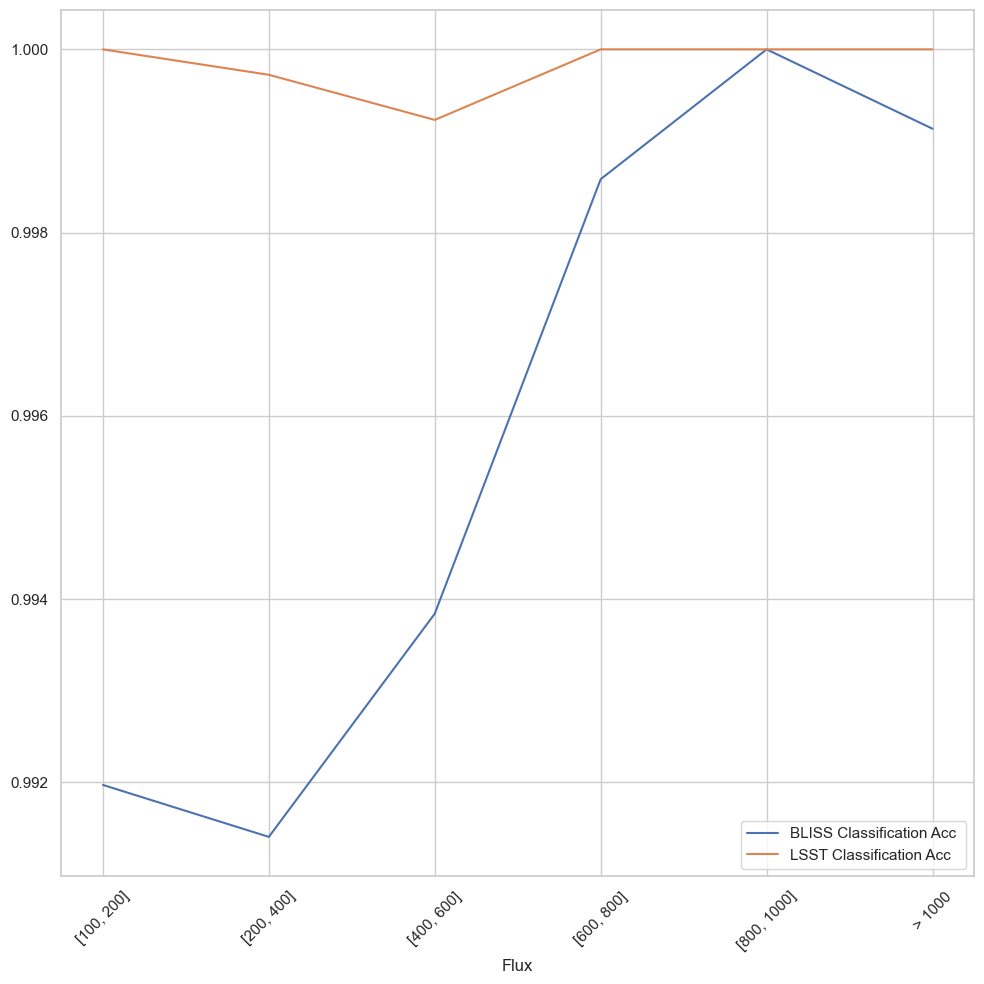

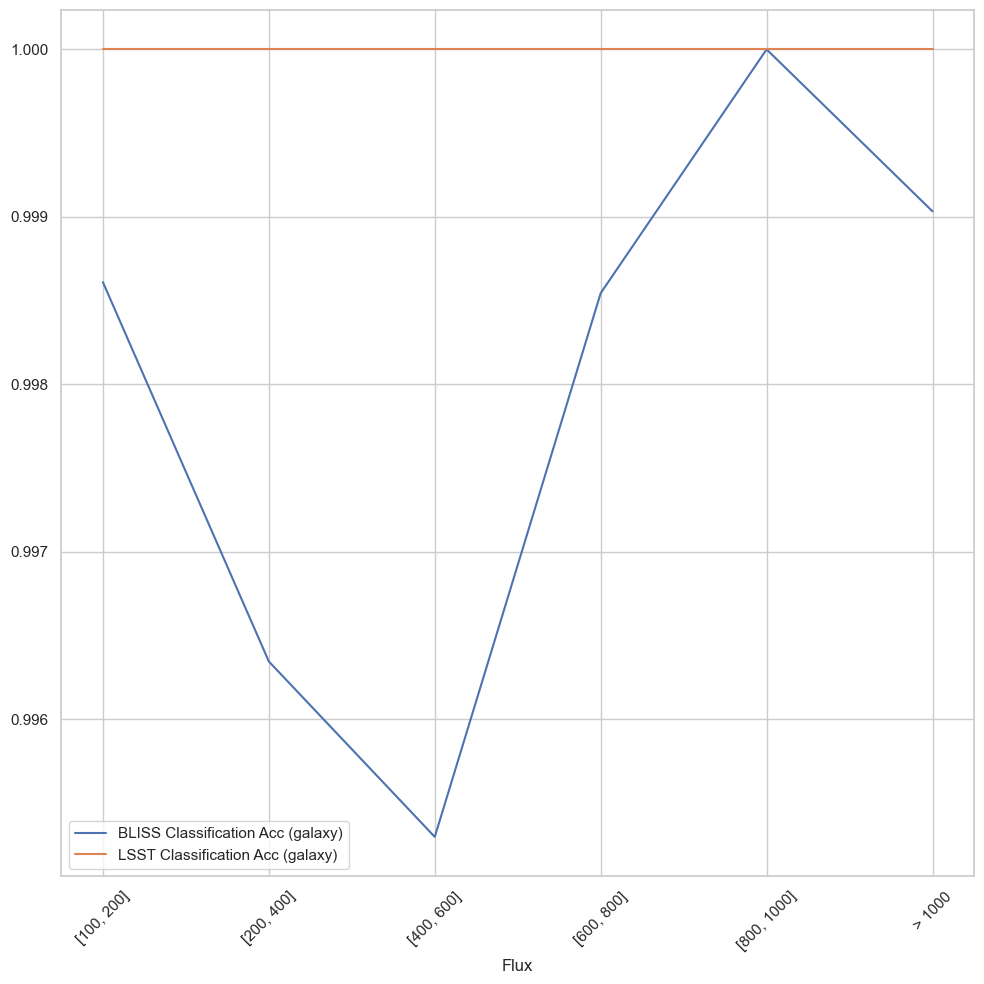

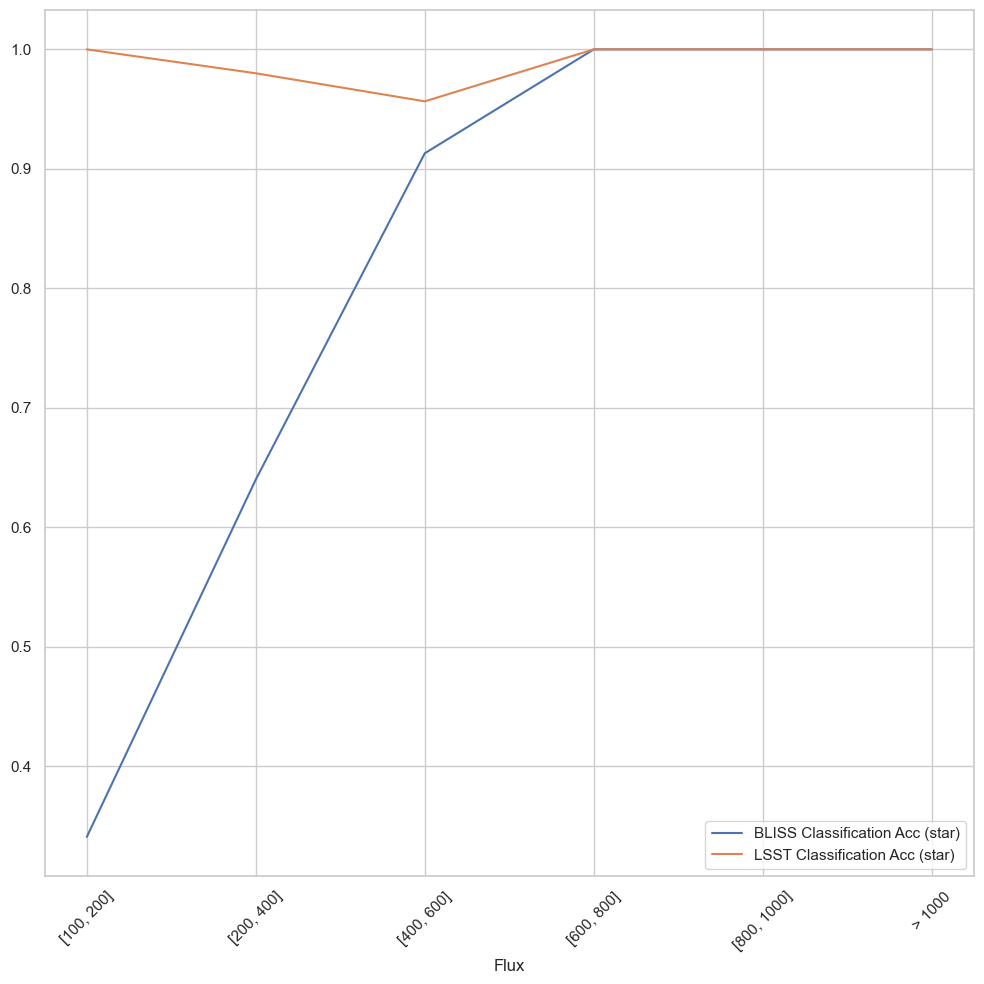

In [28]:
for k, v in bliss_metrics.items():
    flux_bin_cutoffs = v.flux_bin_cutoffs
    postfix_str = v.postfix_str
    fig, ax = plot(bliss_results[f"classification_acc{postfix_str}"],
                    lsst_results[f"classification_acc{postfix_str}"],
                    flux_bin_cutoffs=flux_bin_cutoffs,
                    postfix_str=postfix_str,
                    model_name_1="BLISS",
                    model_name_2="LSST")
    fig.savefig(output_dir / f"classification_acc{postfix_str}.pdf", bbox_inches="tight")
    fig.show()